## Задание 1. A/B–тестирование
<b> Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.</b>
 ## Вопросы

<b><ul> <li>На какие метрики Вы смотрите в ходе анализа и почему?</li>
 <li>Имеются ли различия в показателях и с чем они могут быть связаны?</li>
 <li>Являются ли эти различия статистически значимыми?</li>
 <li>Стоит ли запускать новую механику на всех пользователей?</li></ul></b>
<b>Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.</b>

### В качестве входных данных Вы имеете 4 csv-файла:
<b><ul>
 <li> groups.csv - файл с информацией о принадлежности пользователя к 
  контрольной или экспериментальной группе (А – контроль, B– целевая группа)</li>
 <li> groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных.</li>
 <li> active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.</li> 
 <li> checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.</li></ul> </b>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from urllib.parse import urlencode
from scipy import stats
from scipy.stats import chi2_contingency, norm
from statsmodels. stats.weightstats import ztest as ztest
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['orange'])

In [2]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
groups_url = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ' 
groups_add_url = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_st_url = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ' 
checks_url = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA' 


 
# загружаем файлы 
groups = pd.read_csv(requests.get(base_url + urlencode(dict(public_key=groups_url))).json()['href'], sep=';')
groups_add = pd.read_csv(requests.get(base_url + urlencode(dict(public_key=groups_add_url))).json()['href'], sep=',')
active_st = pd.read_csv(requests.get(base_url + urlencode(dict(public_key=active_st_url))).json()['href'], sep=';')
checks = pd.read_csv(requests.get(base_url + urlencode(dict(public_key=checks_url))).json()['href'], sep=';')

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.shape

(74484, 2)

In [5]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [6]:
groups_add.shape

(92, 2)

In [7]:
active_st.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [8]:
active_st.shape

(8341, 1)

In [9]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [10]:
checks.shape

(541, 2)

Объединяю файл с разбивкой пользователей по группам с дополнительными данными

In [11]:
all_groups = pd.concat([groups,groups_add], axis=0)
all_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [12]:
all_groups = all_groups.rename(columns = {'id' : 'student_id'})
all_groups.head()

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


Теперь надо объединить датафрейм содержащий информацию о пользователях, которые в дни эксперимента заходили на сайт и датафрейм с разбивкой пользователей по группам


In [13]:
active_st_group = active_st.merge(all_groups, how='left', on='student_id')
active_st_group.head()

,student_id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


И теперь в <b>active_st_group</b> добавлю данные с покупками пользователей

In [14]:
experiment = active_st_group.merge(checks, how='left', on='student_id')
experiment.head()

,student_id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN


Все неизвестные значения в столбце rev заменим на нули. Отбрасывать эти значения нельзя, так как они характеризуют поведение пользователей.

In [15]:
experiment['rev'].fillna(0, inplace=True)

In [16]:
experiment

,student_id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0
...,...,...,...
8336,1794344,B,0.0
8337,296883,B,0.0
8338,3598448,B,0.0
8339,3610547,B,290.0


In [17]:
experiment.nunique()

student_id    8341
grp              2
rev             39
dtype: int64

<b>Для оценки влияния новой механики оплаты на сайте при проведении A/B-теста, можно использовать метрики, связанные с конверсией и доходом.</b>

Я рассмотрю следующие метрики:
<ul>
    <li> <b>Конверсия</b> - одна из основных метрик, которая показывает, какая доля пользователей, посетивших сайт, совершает целевое действие. Если новая механика оплаты приводит к увеличению конверсии, то это говорит о ее положительном влиянии.</li>
 <li><b>ARPU</b> - это средний доход, получаемый от каждого пользователя в определенном периоде времени.</li> 
 <li><b>ARPPU</b> - это средний доход, получаемый от каждого платящего пользователя в определенный период времени.  </li>
</ul>

Я создам датафрейм, в котором будет сравнение метрик по группам, для большей наглядности

In [18]:
groupA = experiment.query('grp == "A"')

In [19]:
groupB = experiment.query('grp == "B"')

In [20]:
grp_metrics = experiment.groupby('grp', as_index=False) \
    .agg({'student_id':'count'}) \
    .rename(columns={'student_id':'users_cnt'})
grp_metrics

,grp,users_cnt
0,A,1538
1,B,6803


Добавлю информацию о купивших/не купивших в разбивке по группам

In [21]:
grp_metrics['purch'] = [groupA.query('rev > 0').shape[0],groupB.query('rev > 0').shape[0]]

In [22]:
grp_metrics['no_purch'] = [groupA.query('rev == 0').shape[0],groupB.query('rev == 0').shape[0]]

<b>1. Рассчитаем метрики для 2-х групп</b>

In [23]:
grp_metrics['CR'] = [groupA.query('rev > 0').rev.shape[0]/groupA.rev.shape[0],groupB.query('rev > 0').rev.shape[0]/groupB.rev.shape[0]]

In [24]:
grp_metrics['ARPU'] = [groupA.rev.sum()/groupA.shape[0], groupB.rev.sum()/groupB.shape[0]]

In [25]:
grp_metrics['ARPPU'] = [groupA.rev.sum()/groupA.query('rev > 0').shape[0], groupB.rev.sum()/groupB.query('rev > 0').shape[0]]

In [26]:
grp_metrics

,grp,users_cnt,purch,no_purch,CR,ARPU,ARPPU
0,A,1538,78,1460,0.050715,47.347204,933.589744
1,B,6803,314,6489,0.046156,58.058798,1257.878992


Можно увидеть, что <b>конверсия в целевой группе ниже</b>, но при этом <b> ARPU, ARPPU</b> существенно отличаются.
Скорее всего новая механика оплаты повлияла на сумму оплаты, т.е. пользователи покупают чуть хуже, но при этом чек выше.
Осталось понять, являются ли эти изменения статистически значимыми

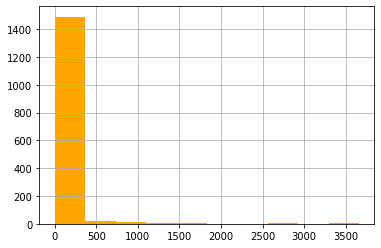

In [27]:
groupA.rev.hist()

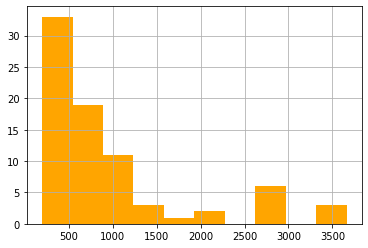

In [28]:
groupA.query('rev > 0').rev.hist()

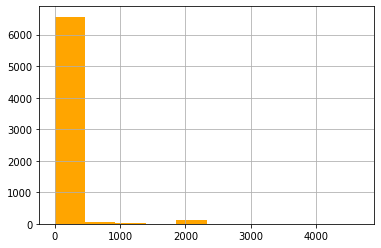

In [29]:
groupB.rev.hist()

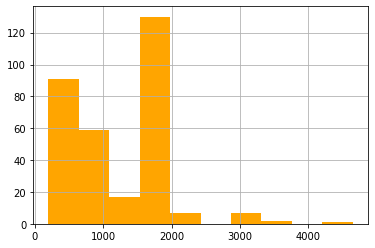

In [30]:
groupB.query('rev > 0').rev.hist()

Распределения revenue в обеих группах отличаются от нормальных. 
Можно заметить, что в целевой группе есть большое количество покупок на чуть меньше 2000 единиц


In [31]:
groupB.rev.value_counts()

0.0000       6489
1900.0000      93
290.0000       45
1900.0001      35
199.0000       27
840.0000       21
990.0000       17
690.0000       13
1140.0000       9
398.0000        6
590.0000        6
580.0000        5
1530.0000       5
870.0000        5
2890.0000       3
2099.0000       3
2910.0000       2
1980.0000       2
3660.0000       2
2220.0000       1
1729.0000       1
3040.0000       1
3260.0000       1
1050.0000       1
796.0000        1
1339.0000       1
4650.0000       1
880.0000        1
2190.0000       1
489.0000        1
597.0000        1
1388.0000       1
1160.0000       1
1968.0000       1
Name: rev, dtype: int64

In [32]:
groupA.rev.value_counts()

0.0       1460
290.0       25
580.0        6
590.0        5
199.0        5
990.0        5
690.0        4
840.0        3
3660.0       3
1530.0       3
2910.0       2
1140.0       2
2820.0       2
1160.0       2
489.0        2
2220.0       1
1039.0       1
2890.0       1
2900.0       1
398.0        1
870.0        1
1980.0       1
1180.0       1
1830.0       1
Name: rev, dtype: int64

на 1900, если быть точнее, возможно новая механика оплаты включает в себя какой-то бонус при покупке на 1900 ??
Тогда этим объясняется такое различие в ARPPU, если учесть, что в группе А нет такого что какая-то сумма денег ярко выражена

In [33]:
grp_metrics

,grp,users_cnt,purch,no_purch,CR,ARPU,ARPPU
0,A,1538,78,1460,0.050715,47.347204,933.589744
1,B,6803,314,6489,0.046156,58.058798,1257.878992


Проверим являются ли изменения в <b>конверсии</b> статистически значимы.  Так как мы имеем информацию о количестве пользователей которые совершили/не совершили целевое действие (категориальные данные) для проверики буду использовать тест хи-квадрат, так как он не требует нормальности распределений.

Для создания таблицы сопряженности можно использовать <b>grp_metrics</b>

In [53]:
contingency_table = np.array(grp_metrics.drop(['users_cnt','grp','CR','ARPU','ARPPU'], axis=1))
contingency_table

array([[  78, 1460],
       [ 314, 6489]])

In [54]:
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
p_value

0.48625240457231045

<b>p_value > 0.05 это означает, что нулевая гипотеза (распределения двух выборок одинаковы) не может быть отвергнута на уровне значимости 0.05. Иначе говоря, нет достаточных доказательств для того, чтобы утверждать, что выборки имеют различия в распределении.</b>

Для проверки статистически значимых изменений в <b>ARPU и ARPPU</b> я буду использовать <b>бутстрап</b>, так как он является непараметрическим методом, не требующим предположений о нормальности распределения, и может быть более точным и полезным методом при малых размерах выборкию

In [36]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('orange')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

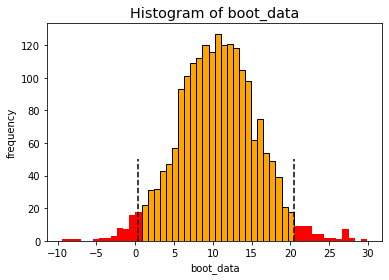

In [37]:
booted_data_arpu = get_bootstrap(groupB.rev, groupA.rev, boot_it = 2000)

In [38]:
booted_data_arpu["p_value"]

0.03862049888119818

In [39]:
booted_data_arpu['quants']

,0
0.025,0.341052
0.975,20.420668


Результаты бутстрапа дают возможность отклонить нулевую гипотезу, т.к. p_value < 0.05 и доверительный интервал выходит за ноль. То есть делаем вывод, что в тестовой и контрольной группе имеются различия в <b>ARPU.</b>

<b>Для ARPPU:</b>

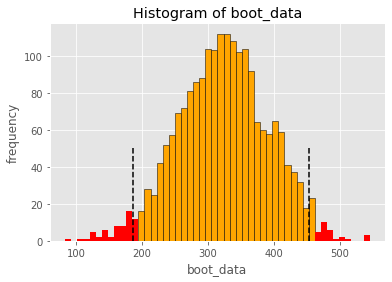

In [40]:
booted_data_arppu = get_bootstrap(groupB.query('rev > 0').rev, groupA.query('rev > 0').rev, boot_it = 2000)

In [41]:
booted_data_arppu['quants']

,0
0.025,185.728830
0.975,454.184489


Результаты бутстрапа дают возможность отклонить нулевую гипотезу, т.к. p_value < 0.05 и доверительный интервал выходит за ноль. То есть делаем вывод, что в тестовой и контрольной группе имеются различия в <b>ARPPU.</b>

### Итого

<b>
В ходе анализа я рассмотрел такие метрики как:
CR - метрика позволяющяя определить эффективность новой механики оплаты
ARPU - метрика позволяет оценить, как новая механика оплаты влияет на средний доход с одного пользователя
ARPPU - также является важной метрикой, она показывает средний доход с каждого платящего пользователя и может помочь понять, насколько успешно новая механика оплаты привлекает и удерживает платежеспособных пользователей.
Интересно, что CR в целевой группе стал ниже, но ARPU и ARPPU выросли существенно. Новая механика оплаты побуждает пользователей отдавать больше денег(очень много платежей по 1900) - это, как мне кажется, оказывает бОльшее влияние на метрику ARPPU, поэтому ее я и выберу в качестве ключевой. Изменение ARPPU и ARPU на основании бутстрапа являются статистически значимыми , а CR на основании хи-квадрат теста - не являются статистически значимыми. 
Считаю, что новую механику надо запускать на всех пользователей.
</b>

## Задание 2. SQL
### Условие
<b>Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.</b>
### Задача
<b>Дана таблица default.peas:</b>
<table style="width:70%">
<tr>
<th>Название атрибута</th>
<th>Тип атрибута</th>
<th>Смысловое значение</th>
</tr>

<tr>
<td>st_id</td>
<td>int</td>
<td>ID ученика</td>
</tr>

<tr>
<td>timest</td>
<td>timestamp</td>
<td>Время решения карточки</td>
</tr>

<tr>
<td>correct</td>
<td>bool</td>
<td>Правильно ли решена горошина?</td>
</tr>

<tr>
<td>subject</td>
<td>text</td>
<td>Дисциплина, в которой находится горошина</td>
</tr> 

</table>

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

NB! Под очень усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [42]:
import pandahouse as ph

In [43]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [44]:
q = '''
    SELECT COUNT(st_id) as st_cnt
    FROM
        (SELECT st_id, SUM(correct) as sum_correct
        FROM default.peas
        WHERE correct = 1
        GROUP BY st_id
        HAVING sum_correct > 20)
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
students = ph.read_clickhouse(query=q, connection=connection_default)
students

,st_cnt
0,130


### Задание 2.2 Оптимизация воронки
### Условие
Образовательная платформа предлагает пройти студентам курсы по модели trial:
студент может решить бесплатно лишь 30 горошин в день. 
Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. 
Команда провела эксперимент, где был протестирован новый экран оплаты.
### Задача
<b>Дана таблицы: default.peas (см. выше), default.studs:</b>
<table style="width:70%">
<tr>
<th>Название атрибута</th>
<th>Тип атрибута</th>
<th>Смысловое значение</th>
</tr>

<tr>
<td>st_id</td>
<td>int</td>
<td>ID ученика</td>
</tr>

<tr>
<td>test_grp</td>
<td>text</td>
<td>Метка ученика в данном эксперименте</td>
</tr>
</table>

<b>и default.final_project_check:</b>

<table style="width:70%">
<tr>
<th>Название атрибута</th>
<th>Тип атрибута</th>
<th>Смысловое значение</th>
</tr>

<tr>
<td>st_id</td>
<td>int</td>
<td>ID ученика</td>
</tr>

<tr>
<td>sale_time</td>
<td>timestamp</td>
<td>Время покупки</td>
</tr>

<tr>
<td>money</td>
<td>int</td>
<td>Цена, по которой приобрели данный курс</td>
</tr>

<tr>
<td>subject</td>
<td>text</td>
<td>Дисциплина, на которую приобрели полный доступ</td>
</tr>

</table>
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
<ul>
<li>ARPU</li>
<li>ARPAU</li>
<li>CR в покупку</li>
<li>СR активного пользователя в покупку</li> 
<li>CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике</li>
</ul>
ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [101]:
a = '''
SELECT 
    test_grp,
    SUM(money)/uniqExact(studs.st_id) as ARPU,
    SUMIf(money, total_peas > 10)/uniqIf(studs.st_id, total_peas > 10) as ARPAU,
    uniqIf(studs.st_id, money > 0)/uniqExact(studs.st_id) * 100 as CR_purchase,
    uniqIf(studs.st_id, money > 0 AND total_peas > 10)/uniqIf(studs.st_id, total_peas > 10) * 100 as CR_active_user,
    uniqIf(studs.st_id, money > 0 AND math >= 2 and subject = 'Math')/
            uniqIf(studs.st_id, math >= 2) * 100 as CR_math_active_user_to_math
    FROM default.studs
    LEFT JOIN (
        SELECT 
            st_id, subject, money
        FROM default.final_project_check
              ) as a 
    ON studs.st_id = a.st_id
            
    LEFT JOIN (
        SELECT
            st_id,
            SUM(correct) as total_peas,
            SUMIf(correct, subject = 'Math') as math
                FROM default.peas
                GROUP BY st_id
                ) as math_peas 
                ON studs.st_id = math_peas.st_id
GROUP BY test_grp    
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
metrics = ph.read_clickhouse(query=a, connection=connection_default)
metrics

,test_grp,ARPU,ARPAU,CR_purchase,CR_active_user,CR_math_active_user_to_math
0,control,4540.983607,10393.700787,4.918033,11.023622,6.122449
1,pilot,11508.474576,29739.583333,10.847458,26.041667,9.523810


### Задание 3. Python
<ol>
<li>Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла <b>groups_add.csv</b> (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.</li>
<li>Реализуйте функцию, которая будет строить графики по получаемым метрикам.</li>
</ol>

In [97]:
def update_metrics(groups, groups_add, active_st, checks):
    """Эта функция принимает на вход датафреймы groups, groups_add, active_st, checks и на основании доп.
    данных из файла groups_add пересчитывает метрики".

    Args:
        groups, groups_add, active_st, checks

    Returns:
        Возвращает таблицу с пересчитанными метриками
    """
    # переименовываем слобцы groups_add
    groups_add.columns = groups.columns
    # Объединяю файл с разбивкой пользователей по группам с дополнительными данными
    all_groups = pd.concat([groups, groups_add])
    all_groups = all_groups.rename(columns={'id': 'student_id'})
    # Объединяю датафрейм содержащий информацию о пользователях, которые в дни эксперимента заходили на сайт
    # и датафрейм с разбивкой пользователей по группам
    active_st_group = active_st.merge(all_groups, how='left', on='student_id')
    # Добавляю данные с покупками пользователей
    experiment = active_st_group.merge(checks, how='left', on='student_id').fillna(0)
    groupA = experiment.query('grp == "A"')
    groupB = experiment.query('grp == "B"')
    # Рассчет метрик
    grp_metrics = experiment.groupby('grp', as_index=False) \
        .agg({'student_id': 'count'}) \
        .rename(columns={'student_id': 'users_cnt'})
    grp_metrics['purch'] = [groupA.query('rev > 0').shape[0], groupB.query('rev > 0').shape[0]]
    grp_metrics['no_purch'] = [groupA.query('rev == 0').shape[0],groupB.query('rev == 0').shape[0]]
    grp_metrics['CR'] = [groupA.query('rev > 0').rev.shape[0] / groupA.rev.shape[0],
                         groupB.query('rev > 0').rev.shape[0] / groupB.rev.shape[0]]
    grp_metrics['ARPU'] = [groupA.rev.sum() / groupA.shape[0], groupB.rev.sum() / groupB.shape[0]]
    grp_metrics['ARPPU'] = [groupA.rev.sum()/groupA.query('rev > 0').shape[0], groupB.rev.sum()/groupB.query('rev > 0').shape[0]]
    return grp_metrics

In [98]:
update_metrics(groups,groups_add,active_st,checks)

,grp,users_cnt,purch,no_purch,CR,ARPU,ARPPU
0,A,1538,78,1460,0.050715,47.347204,933.589744
1,B,6803,314,6489,0.046156,58.058798,1257.878992


In [99]:
def plot_metrics(data):
    """Эта функция принимает на таблицу с посчитанными метриками".

    Args:
        data

    Returns:
        Графики по получаемым метрикам
    """
    
    # Построение графиков
    plt.bar(data['grp'], data['users_cnt'], color='blue')
    plt.xlabel('Группа')
    plt.ylabel('Кол-во пользователей')
    plt.title('Кол-во пользователей по группам')
    plt.show()
    
    plt.bar(data['grp'], data['purch'], color='blue')
    plt.xlabel('Группа')
    plt.ylabel('Кол-во покупателей')
    plt.title('Кол-во покупателей по группам')
    plt.show()
    
    plt.bar(data['grp'], data['no_purch'], color='blue')
    plt.xlabel('Группа')
    plt.ylabel('Кол-во не купивших пользователей')
    plt.title('Кол-во не купивших пользователей по группам')
    plt.show()
    
    plt.bar(data['grp'], data['CR'], color='grey')
    plt.xlabel('Группа')
    plt.ylabel('CR')
    plt.title('CR по группам')
    plt.show()
    
    plt.bar(data['grp'], data['ARPU'], color='green')
    plt.xlabel('Группа')
    plt.ylabel('ARPU')
    plt.title('ARPU по группам')
    plt.show()
    
    plt.bar(data['grp'], data['ARPPU'], color='orange')
    plt.xlabel('Группа')
    plt.ylabel('ARPPU')
    plt.title('ARPPU по группам')
    plt.show()

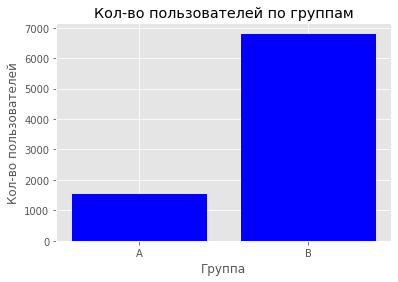

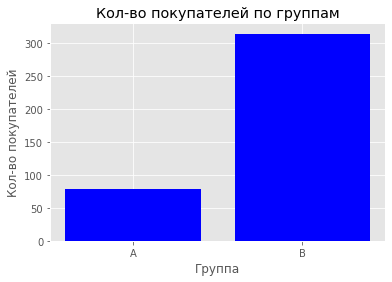

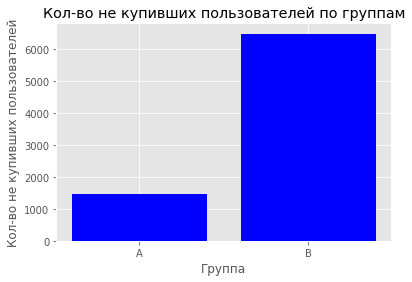

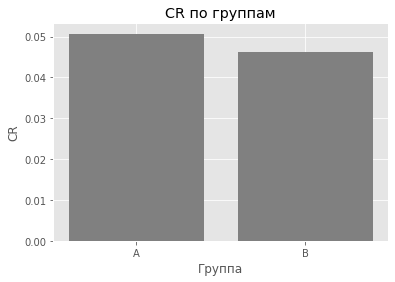

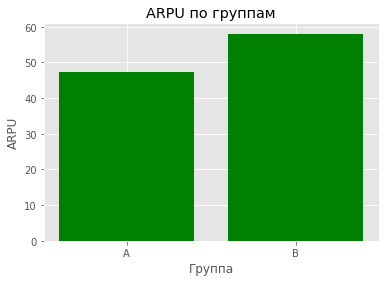

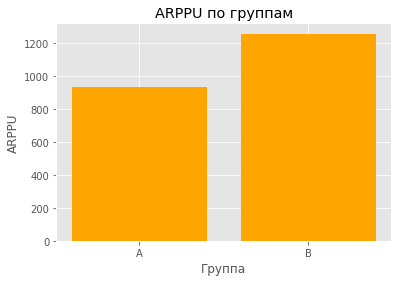

In [100]:
plot_metrics(grp_metrics)